## Dipole Current Distribution using Method of Moments
As described in Antenna Theory and Design by Constantine Balanis

#### Imports

In [34]:
import numpy as np
import matplotlib.pyplot as plt

#### Specify Geometry

In [35]:
N = 101 # Number of Segments
l = 0.47 # Length in wavelengths
a = 0.005 # Radius in wavelengths 

#### Current Distribution Calculation

Pocklington’s integral equation

In [36]:
def pock_eqn(zm, zn, a):
    k = 2*np.pi
    R = np.sqrt(a**2+(zm-zn)**2)
    return np.exp(-1j*k*R)/(4*np.pi*R**5)*((1+1j*k*R)*(2*R**2-3*a**2)+(k*a*R)**2)

Solve for Current Distribution using Method of Moments

In [37]:
delta = l/N
s = 10000
E = np.zeros((N,1), dtype=complex)
E[int(np.floor(N/2))] = -1j*2*np.pi/(120*np.pi*delta);
Z = np.zeros((N,N), dtype=complex)
for m in range (N):
    zm = -l/2+(m+0.5)*delta
    for n in range (N):
        zn = -l/2+(n+0.5)*delta
        Z[m,n] = np.sum(pock_eqn(zm, np.linspace(zn-0.5*delta, zn+0.5*delta, s), a))*delta/s
I = np.linalg.solve(Z,E)

#### Current Distribution Plot

Text(0, 0.5, 'Normalized Current Magnitude')

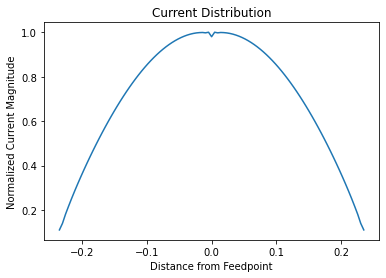

In [46]:
plt.figure()
plt.plot(np.linspace(0,l,N) - l/2, np.abs(I / np.max(np.abs(I))))
plt.title("Current Distribution")
plt.xlabel("Distance from Feedpoint")
plt.ylabel("Normalized Current Magnitude")

Impedance Calculation

In [39]:
1/I[int(np.floor(N/2))]

array([82.34744353+8.91500724j])